In [1]:
import pandas as pd
import datetime
import numpy as np

# local file paths
input_file_path = f'../../../siads591 data/filtered_raw/gabbard_min.pkl.gz'
out_path = f'../../../siads591 data/processed_data/gabbard/'

# freq             frequency of datapoints after reindexing
# start_date       start date for data to start processing - remember to leave enough gap for interpolation
# interpolate_lim  limits of interpolation based on the frequency
#                  (1D frequency, 30 limit = 30 days 1 way, effectively a max of 60 days between points)
# out_file_name    output file name

# freq, start_date, interpolate_lim, out_file_name = '1D', '1979-10-01', 45, 'gabbard_1D_scaled_1980.pkl'
freq, start_date, interpolate_lim, out_file_name = '1D', None, 10, 'gabbard_1D_scaled_il10.pkl'
# freq, start_date, interpolate_lim, out_file_name = '12H', '1979-10-01', 90, 'gabbard_scaled_1980.pkl'
# freq, start_date, interpolate_lim, out_file_name = '5D', None, 12, 'gabbard_5D_scaled.pkl'

In [2]:
raw_df = pd.read_pickle(f'{input_file_path}', compression="gzip")

In [3]:
raw_df = raw_df.reset_index().sort_values(by=["EPOCH","NORAD_CAT_ID"]).drop_duplicates(subset=["EPOCH","NORAD_CAT_ID"]).set_index("EPOCH")

In [4]:
if start_date != None:
    raw_df = raw_df[raw_df.index > start_date]

In [5]:
display(raw_df.head(4))
display(raw_df.info())

,NORAD_CAT_ID,PERIOD_x500,APOAPSIS_x20,PERIAPSIS_x20
EPOCH,,,,
1959-10-24 11:14:07.924127,23,50681,21830,11100
1959-11-03 17:34:40.920383,23,50675,21803,11100
1959-11-10 18:16:00.424991,23,50668,21779,11100
1959-11-17 18:56:50.595935,23,50665,21768,11100


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84875328 entries, 1959-10-24 11:14:07.924127 to 2021-01-26 04:48:39.119328
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   NORAD_CAT_ID   uint16
 1   PERIOD_x500    UInt16
 2   APOAPSIS_x20   UInt16
 3   PERIAPSIS_x20  UInt16
dtypes: UInt16(3), uint16(1)
memory usage: 1.5 GB


None

In [6]:
# create a new dataframe with min/max epoch of each satellite
reindexed_df = raw_df.reset_index().groupby(by="NORAD_CAT_ID").agg({'EPOCH':['min','max']})

# rename columns and add a joining column.  Boolean is the least memory intensive.
reindexed_df.columns = ["_".join(x) for x in reindexed_df.columns.ravel()]
reindexed_df['key'] = True

# generate valid EPOCH entries for each satellite
reindexed_df = reindexed_df.reset_index().merge(pd.DataFrame({'EPOCH':pd.date_range(start=raw_df.index.floor(freq=freq).min(), end=raw_df.index.max(), freq=freq),'key':True}),on='key').drop('key',1)
reindexed_df = reindexed_df[(reindexed_df.EPOCH_min < reindexed_df.EPOCH) & (reindexed_df.EPOCH_max > reindexed_df.EPOCH)][['NORAD_CAT_ID','EPOCH']]

# save this value for later use
num_rows = len(reindexed_df)

# combine the generated table with the raw data
reindexed_df = reindexed_df.append(raw_df.reset_index(), ignore_index=True).sort_values(by=['NORAD_CAT_ID','EPOCH'])
reindexed_df["NORAD_CAT_ID"] = reindexed_df["NORAD_CAT_ID"].astype(np.uint16)

reindexed_df = reindexed_df.reset_index().rename(columns={"index":"old_index"}).set_index("EPOCH")

# interpolate values for the generated EPOCH, col by col
reindexed_df["PERIOD_x500"] = reindexed_df["PERIOD_x500"].astype(np.float32).interpolate(method='time', limit_area="inside", limit=interpolate_lim, limit_direction='both').round(0).astype(pd.UInt16Dtype())
reindexed_df["APOAPSIS_x20"] = reindexed_df["APOAPSIS_x20"].astype(np.float32).interpolate(method='time', limit_area="inside", limit=interpolate_lim, limit_direction='both').round(0).astype(pd.UInt16Dtype())
reindexed_df["PERIAPSIS_x20"] = reindexed_df["PERIAPSIS_x20"].astype(np.float32).interpolate(method='time', limit_area="inside", limit=interpolate_lim, limit_direction='both').round(0).astype(pd.UInt16Dtype())

# remove the raw data
reindexed_df = reindexed_df[reindexed_df.old_index < num_rows]
reindexed_df = reindexed_df.drop(columns=["old_index"])

In [7]:
display(reindexed_df.head(4))
display(reindexed_df.info())

,NORAD_CAT_ID,PERIOD_x500,APOAPSIS_x20,PERIAPSIS_x20
EPOCH,,,,
1987-12-22,12,52156,20451,18028
1987-12-23,12,48928,13615,12601
1987-12-24,12,55924,30704,21760
1987-12-25,12,51887,24154,13181


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99798124 entries, 1987-12-22 to 2021-01-26
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   NORAD_CAT_ID   uint16
 1   PERIOD_x500    UInt16
 2   APOAPSIS_x20   UInt16
 3   PERIAPSIS_x20  UInt16
dtypes: UInt16(3), uint16(1)
memory usage: 1.8 GB


None

In [8]:
reindexed_df.to_pickle(f"{out_path}{out_file_name}")

<AxesSubplot:>

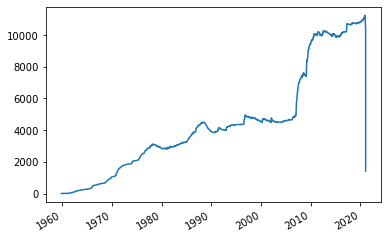

In [9]:
reindexed_df.index.value_counts().plot()